<a href="https://colab.research.google.com/github/PadalaKavya/MajorProject/blob/master/Multiclass_lstm%2CBI_LSTM%2Ccnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Custom functions definition:

In [ ]:
def conf_matrix(y, y_pred, title, labels):
    fig, ax =plt.subplots(figsize=(7.5,7.5))
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Purples", fmt='g', cbar=False, annot_kws={"size":30})
    plt.title(title, fontsize=25)
    ax.xaxis.set_ticklabels(labels, fontsize=16) 
    ax.yaxis.set_ticklabels(labels, fontsize=14.5)
    ax.set_ylabel('Test', fontsize=25)
    ax.set_xlabel('Predicted', fontsize=25)
    plt.show()

In [ ]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Import libraries

In [ ]:
#Libraries for general purpose
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Text cleaning
import re, string
!pip install emoji
import emoji
import nltk 
nltk.download('stopwords')
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

#Data preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

#Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB


#PyTorch LSTM
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#Tokenization for LSTM
from collections import Counter
from gensim.models import Word2Vec

#Transformers library for BERT
!pip install transformers
import transformers
from transformers import BertModel
from transformers import BertTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup

from sklearn.metrics import classification_report, confusion_matrix

#Seed for reproducibility
import random

seed_value=42
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

import time

#set style for plots
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)
%matplotlib inline
!pip install gensim
import warnings
warnings.filterwarnings(action = 'ignore')
import gensim
from gensim.models import Word2Vec


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<Figure size 640x480 with 0 Axes>

## Data Import

In [ ]:
df = pd.read_csv("cyberbullying_tweets.csv")

In [ ]:
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


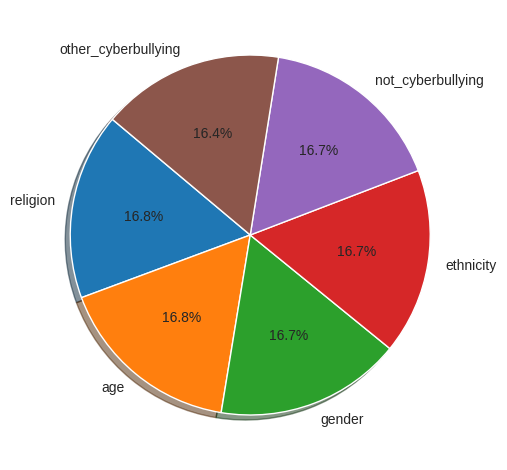

In [ ]:
import matplotlib.pyplot as plt
type_count = df['cyberbullying_type'].value_counts()
plt.pie(type_count, labels=type_count.index,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.show()

In [ ]:
df = df.rename(columns={'tweet_text': 'text', 'cyberbullying_type': 'sentiment'})

In [ ]:
df.sentiment.value_counts()

religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: sentiment, dtype: int64

# Tweets text deep cleaning

In [ ]:
##CUSTOM DEFINED FUNCTIONS TO CLEAN THE TWEETS

#Remove punctuations, links, stopwords, mentions and \r\n new line characters
def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    text = [word for word in text.split() if word not in stop_words]
    text = ' '.join(text)
    text =' '.join(word for word in text.split() if len(word) < 14) # remove words longer than 14 characters
    return text

#remove contractions
def decontract(text):
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text

#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the "#" symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#Filter special characters such as "&" and "$" present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

#Remove multiple sequential spaces
def remove_mult_spaces(text):
    return re.sub("\s\s+" , " ", text)

#Stemming
def stemmer(text):
    tokenized = nltk.word_tokenize(text)
    ps = PorterStemmer()
    return ' '.join([ps.stem(words) for words in tokenized])

#Lemmatization 
#NOTE:Stemming seems to work better for this dataset
def lemmatize(text):
    tokenized = nltk.word_tokenize(text)
    lm = WordNetLemmatizer()
    return ' '.join([lm.lemmatize(words) for words in tokenized])

#Then we apply all the defined functions in the following order
def deep_clean(text):
    
    text = decontract(text)
    text = strip_all_entities(text)
    text = clean_hashtags(text)
    text = filter_chars(text)
    text = remove_mult_spaces(text)
    text = stemmer(text)
    return text

In [ ]:
texts_new = []
for t in df.text:
    texts_new.append(deep_clean(t))

In [ ]:
df['text_clean'] = texts_new

In [ ]:
df.head()

,text,sentiment,text_clean
0,"In other words #katandandre, your food was cra...",not_cyberbullying,word katandandr food crapilici mkr
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,aussietv white mkr theblock today sunris studi...
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,classi whore red velvet cupcak
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,meh p thank head concern anoth angri dude twitter
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,isi account pretend kurdish account like islam...


In [ ]:
df.shape

(47692, 3)

In [ ]:
df["text_clean"].duplicated().sum()

3094

In [ ]:
df.drop_duplicates("text_clean", inplace=True)

In [ ]:
df.shape

(44598, 3)

In [ ]:
df

,text,sentiment,text_clean
0,"In other words #katandandre, your food was cra...",not_cyberbullying,word katandandr food crapilici mkr
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,aussietv white mkr theblock today sunris studi...
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,classi whore red velvet cupcak
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,meh p thank head concern anoth angri dude twitter
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,isi account pretend kurdish account like islam...
...,...,...,...
47687,"Black ppl aren't expected to do anything, depe...",ethnicity,black ppl expect anyth depend anyth yet free p...
47688,Turner did not withhold his disappointment. Tu...,ethnicity,turner withhold turner call court abomin concl...
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity,swear god dumb nigger bitch got bleach hair re...
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity,yea fuck rt your nigger fuck unfollow fuck dum...


In [ ]:
df.sentiment.value_counts()

religion               7946
age                    7884
ethnicity              7744
not_cyberbullying      7637
gender                 7607
other_cyberbullying    5780
Name: sentiment, dtype: int64

In [ ]:
df = df[df["sentiment"]!="other_cyberbullying"]

In [ ]:
sentiments = ["religion","age","ethnicity","gender","not bullying"]

# Tweets length analysis

In [ ]:
text_len = []
for text in df.text_clean:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

In [ ]:
df['text_len'] = text_len

In [ ]:
'''
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df[df['text_len']<10], palette='mako')
plt.title('Count of tweets with less than 10 words', fontsize=20)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()
'''

"\nplt.figure(figsize=(7,5))\nax = sns.countplot(x='text_len', data=df[df['text_len']<10], palette='mako')\nplt.title('Count of tweets with less than 10 words', fontsize=20)\nplt.yticks([])\nax.bar_label(ax.containers[0])\nplt.ylabel('count')\nplt.xlabel('')\nplt.show()\n"

In [ ]:
df = df[df['text_len'] > 3]

In [ ]:
df.sort_values(by=['text_len'], ascending=False)

,text,sentiment,text_clean,text_len
44035,You so black and white trying to live like a n...,ethnicity,black white tri live like nigger pahahahaha co...,187
45165,"@hermdiggz: “@tayyoung_: FUCK OBAMA, dumb ass ...",ethnicity,fuck obama dumb ass nigger bitch ltthi whore s...,162
33724,"... I don't feel guilty for killing him, I jus...",age,feel guilti kill feel guilti enjoy torment sin...,137
1317,@EurekAlertAAAS: Researchers push to import to...,not_cyberbullying,research push import top antibulli program us ...,137
47037,@Purely_Ambition: Sooo mad. RT @TracePeterson ...,ethnicity,sooo mad rt fuck obama dumb nigger go switzerl...,125
...,...,...,...,...
10274,@holliebakerlutz What does that 23% figure rep...,gender,23 figur repres deriv,4
5229,are bully sticks for dogs safe,not_cyberbullying,bulli stick dog safe,4
10314,RT @Mr_LayedBak: I'm not sexist... but women r...,gender,rt sexist women ref,4
5237,*hands you a bag of trail mix*,not_cyberbullying,hand bag trail mix,4


In [ ]:
'''
plt.figure(figsize=(16,5))
ax = sns.countplot(x='text_len', data=df[(df['text_len']<=1000) & (df['text_len']>10)], palette='Blues_r')
plt.title('Count of tweets with high number of words', fontsize=25)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()
'''

"\nplt.figure(figsize=(16,5))\nax = sns.countplot(x='text_len', data=df[(df['text_len']<=1000) & (df['text_len']>10)], palette='Blues_r')\nplt.title('Count of tweets with high number of words', fontsize=25)\nplt.yticks([])\nax.bar_label(ax.containers[0])\nplt.ylabel('count')\nplt.xlabel('')\nplt.show()\n"

In [ ]:
df = df[df['text_len'] < 100]

In [ ]:
max_len = np.max(df['text_len'])
max_len 

79

In [ ]:
df.sort_values(by=["text_len"], ascending=False)

,text,sentiment,text_clean,text_len
4846,@andrea_gcav: @viviaanajim recuerdas como noso...,not_cyberbullying,recuerda como nosotra tambin eramo victima del...,79
44294,@JasmineLovvee If He Dont Want You Well Fuck H...,ethnicity,dont want well fuck aint worth tear never swea...,73
45930,"Get off ur ego trip, take off ur rose colored ...",ethnicity,get ur ego trip take ur rose color glass amp g...,45
21241,And yet God was able to meet their needs using...,religion,yet god abl meet need use radic everyday gener...,43
41749,@seijohgorl hoy mami keito AAAA okay so um ika...,ethnicity,hoy mami keito aaaa okay um ikaw talaga one fi...,43
...,...,...,...,...
44750,What the fuck you dumb nigger I hate you now,ethnicity,fuck dumb nigger hate,4
1673,@UMTony lmao! I really wanted to take it down!,not_cyberbullying,lmao realli want take,4
35335,He's a grade school bully. He's a coward!,age,grade school bulli coward,4
3920,Need to let my anger out dude.,not_cyberbullying,need let anger dude,4


## Sentiment column encoding

In [ ]:
df['sentiment'] = df['sentiment'].replace({'religion':0,'age':1,'ethnicity':2,'gender':3,'not_cyberbullying':4})

## Train - Test split

In [ ]:
X = df['text_clean']
y = df['sentiment']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)

##**Train - Validation split**

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=seed_value)

In [ ]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 5051],
       [   1, 5011],
       [   2, 4933],
       [   3, 4679],
       [   4, 4078]])

# Oversampling of training set

In [ ]:
ros = RandomOverSampler()
X_train, y_train = ros.fit_resample(np.array(X_train).reshape(-1, 1), np.array(y_train).reshape(-1, 1));
train_os = pd.DataFrame(list(zip([x[0] for x in X_train], y_train)), columns = ['text_clean', 'sentiment']);

In [ ]:
X_train = train_os['text_clean'].values
y_train = train_os['sentiment'].values

In [ ]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 5051],
       [   1, 5051],
       [   2, 5051],
       [   3, 5051],
       [   4, 5051]])

In [ ]:
#ML ALGOS


# PyTorch Bi-LSTM RNN

# Data preprocessing for LSTM

In [ ]:
def Tokenize(column, seq_len):
    ##Create vocabulary of words from column
    corpus = [word for text in column for word in text.split()]
    count_words = Counter(corpus)
    sorted_words = count_words.most_common()
    vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}

    ##Tokenize the columns text using the vocabulary
    text_int = []
    for text in column:
        r = [vocab_to_int[word] for word in text.split()]
        text_int.append(r)
    ##Add padding to tokens
    features = np.zeros((len(text_int), seq_len), dtype = int)
    for i, review in enumerate(text_int):
        if len(review) <= seq_len:
            zeros = list(np.zeros(seq_len - len(review)))
            new = zeros + review
        else:
            new = review[: seq_len]
        features[i, :] = np.array(new)

    return sorted_words, features

In [ ]:
vocabulary, tokenized_column = Tokenize(df["text_clean"], max_len)

In [ ]:
df["text_clean"].iloc[10]

'love best respons hotcak manag film noncommitt meh adolesc mkr'

In [ ]:
tokenized_column[10]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,    66,   219,   503,
        8001,  1300,  1142, 13587,  4686,  9804,    34])

In [ ]:
keys = []
values = []
for key, value in vocabulary[:20]:
    keys.append(key)
    values.append(value)

In [ ]:
'''
#from axesSubplot isport bar_label
plt.figure(figsize=(15, 5))
ax = sns.barplot(keys, values, palette='mako')
plt.title('Top 20 most common words', size=25)
ax.bar_label(ax.containers[0])
plt.ylabel("Words count")
plt.show()
'''

'\n#from axesSubplot isport bar_label\nplt.figure(figsize=(15, 5))\nax = sns.barplot(keys, values, palette=\'mako\')\nplt.title(\'Top 20 most common words\', size=25)\nax.bar_label(ax.containers[0])\nplt.ylabel("Words count")\nplt.show()\n'

# Word Embedding by Word2Vec

In [ ]:
Word2vec_train_data = list(map(lambda x: x.split(), X_train))

In [ ]:
EMBEDDING_DIM = 200

In [ ]:
!pip install gensim==3.8



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from gensim.models import Word2Vec
word2vec_model = Word2Vec(Word2vec_train_data, size=EMBEDDING_DIM)

In [ ]:
print(f"Vocabulary size: {len(vocabulary) + 1}")

Vocabulary size: 33009


In [ ]:
VOCAB_SIZE = len(vocabulary) + 1 #+1 for the padding

In [ ]:
#define empty embedding matrix
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))
    
#fill the embedding matrix with the pre trained values from word2vec
#    corresponding to word (string), token (number associated to the word)
for word, token in vocabulary:
    if word2vec_model.wv.__contains__(word):
        embedding_matrix[token] = word2vec_model.wv.__getitem__(word)

print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (33009, 200)


## Train - Validation - Test split

Now we will use the tokenized sentences to create a training, validation and test datasets.

In [ ]:
X = tokenized_column
y = df['sentiment'].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=seed_value)

We can check the balance of the target classes:

In [ ]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 5683],
       [   1, 5638],
       [   2, 5549],
       [   3, 5264],
       [   4, 4587]])

And then apply random oversampling on the training set.

In [ ]:
ros = RandomOverSampler()
X_train_os, y_train_os = ros.fit_resample(np.array(X_train),np.array(y_train));

In [ ]:
(unique, counts) = np.unique(y_train_os, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 5683],
       [   1, 5683],
       [   2, 5683],
       [   3, 5683],
       [   4, 5683]])

## PyTorch datasets and dataloaders

The three sets will be transformed to tensor datasets and dataloaders so we can extract the data in batches for the LSTM training, validation and testing.

In [ ]:
train_data = TensorDataset(torch.from_numpy(X_train_os), torch.from_numpy(y_train_os))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
valid_data = TensorDataset(torch.from_numpy(X_valid), torch.from_numpy(y_valid))

In [ ]:
BATCH_SIZE = 32

In [ ]:
train_loader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE, drop_last=True) 
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)
test_loader = DataLoader(test_data, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)

# PyTorch LSTM modeling

Finally we can start the LSTM modeling. We start by setting some hyperparameters.

In [ ]:
NUM_CLASSES = 5 #We are dealing with a multiclass classification of 5 classes
HIDDEN_DIM = 100 #number of neurons of the internal state (internal neural network in the LSTM)
LSTM_LAYERS = 1 #Number of stacked LSTM layers

LR = 3e-4 #Learning rate
DROPOUT = 0.5 #LSTM Dropout
BIDIRECTIONAL = True #Boolean value to choose if to use a bidirectional LSTM or not
EPOCHS = 5 #Number of training epoch

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
class BiLSTM_Sentiment_Classifier(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, lstm_layers, bidirectional,batch_size, dropout):
        super(BiLSTM_Sentiment_Classifier,self).__init__()
        
        self.lstm_layers = lstm_layers
        self.num_directions = 2 if bidirectional else 1
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes
        self.batch_size = batch_size
        

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.lstm = nn.LSTM(embedding_dim,
                            hidden_dim,
                            num_layers=lstm_layers,
                            dropout=dropout,
                            bidirectional=bidirectional,
                            batch_first=True)

        self.fc = nn.Linear(hidden_dim*self.num_directions, num_classes)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x, hidden):
        self.batch_size = x.size(0)
        ##EMBEDDING LAYER
        embedded = self.embedding(x)
        #LSTM LAYERS
        out, hidden = self.lstm(embedded, hidden)
        #Extract only the hidden state from the last LSTM cell
        out = out[:,-1,:]
        #FULLY CONNECTED LAYERS
        out = self.fc(out)
        out = self.softmax(out)

        return out, hidden

    def init_hidden(self, batch_size):
        #Initialization of the LSTM hidden and cell states
        h0 = torch.zeros((self.lstm_layers*self.num_directions, batch_size, self.hidden_dim)).detach().to(DEVICE)
        c0 = torch.zeros((self.lstm_layers*self.num_directions, batch_size, self.hidden_dim)).detach().to(DEVICE)
        hidden = (h0, c0)
        return hidden

In [ ]:
model = BiLSTM_Sentiment_Classifier(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM,NUM_CLASSES, LSTM_LAYERS,BIDIRECTIONAL, BATCH_SIZE, DROPOUT)
model = model.to(DEVICE)

#Initialize embedding with the previously defined embedding matrix
model.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
#Allow the embedding matrix to be fined tuned to better adapt to out dataset and get higher accuracy
model.embedding.weight.requires_grad=True

print(model)

BiLSTM_Sentiment_Classifier(
  (embedding): Embedding(33009, 200)
  (lstm): LSTM(200, 100, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=200, out_features=5, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [ ]:
criterion = nn.NLLLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay = 5e-6)

# LSTM Training loop 

Now we will define a custom training loop, where we include an early stopping functionality, and save only the best models in terms of validation accuracy.

In [ ]:
total_step = len(train_loader)
total_step_val = len(valid_loader)

early_stopping_patience = 4
early_stopping_counter = 0

valid_acc_max = 0 # Initialize best accuracy top 0

for e in range(EPOCHS):

    #lists to host the train and validation losses of every batch for each epoch
    train_loss, valid_loss  = [], []
    #lists to host the train and validation accuracy of every batch for each epoch
    train_acc, valid_acc  = [], []

    #lists to host the train and validation predictions of every batch for each epoch
    y_train_list, y_val_list = [], []

    #initalize number of total and correctly classified texts during training and validation
    correct, correct_val = 0, 0
    total, total_val = 0, 0
    running_loss, running_loss_val = 0, 0


    ####TRAINING LOOP####

    model.train()

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE) #load features and targets in device

        h = model.init_hidden(labels.size(0))

        model.zero_grad() #reset gradients 

        output, h = model(inputs,h) #get output and hidden states from LSTM network
        
        loss = criterion(output, labels)
        loss.backward()
        
        running_loss += loss.item()
        
        optimizer.step()

        y_pred_train = torch.argmax(output, dim=1) #get tensor of predicted values on the training set
        y_train_list.extend(y_pred_train.squeeze().tolist()) #transform tensor to list and the values to the list
        
        correct += torch.sum(y_pred_train==labels).item() #count correctly classified texts per batch
        total += labels.size(0) #count total texts per batch

    train_loss.append(running_loss / total_step)
    train_acc.append(100 * correct / total)

    ####VALIDATION LOOP####
    
    with torch.no_grad():
        
        model.eval()
        
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            val_h = model.init_hidden(labels.size(0))

            output, val_h = model(inputs, val_h)

            val_loss = criterion(output, labels)
            running_loss_val += val_loss.item()

            y_pred_val = torch.argmax(output, dim=1)
            y_val_list.extend(y_pred_val.squeeze().tolist())

            correct_val += torch.sum(y_pred_val==labels).item()
            total_val += labels.size(0)

        valid_loss.append(running_loss_val / total_step_val)
        valid_acc.append(100 * correct_val / total_val)

    #Save model if validation accuracy increases
    if np.mean(valid_acc) >= valid_acc_max:
        torch.save(model.state_dict(), './state_dict.pt')
        print(f'Epoch {e+1}:Validation accuracy increased ({valid_acc_max:.6f} --> {np.mean(valid_acc):.6f}).  Saving model ...')
        valid_acc_max = np.mean(valid_acc)
        early_stopping_counter=0 #reset counter if validation accuracy increases
    else:
        print(f'Epoch {e+1}:Validation accuracy did not increase')
        early_stopping_counter+=1 #increase counter if validation accuracy does not increase
        
    if early_stopping_counter > early_stopping_patience:
        print('Early stopped at epoch :', e+1)
        break
    
    print(f'\tTrain_loss : {np.mean(train_loss):.4f} Val_loss : {np.mean(valid_loss):.4f}')
    print(f'\tTrain_acc : {np.mean(train_acc):.3f}% Val_acc : {np.mean(valid_acc):.3f}%')



Epoch 1:Validation accuracy increased (0.000000 --> 90.353261).  Saving model ...
	Train_loss : 0.0022 Val_loss : 0.5701
	Train_acc : 99.933% Val_acc : 90.353%
Epoch 2:Validation accuracy did not increase
	Train_loss : 0.0014 Val_loss : 0.6083
	Train_acc : 99.961% Val_acc : 90.183%
Epoch 3:Validation accuracy increased (90.353261 --> 90.353261).  Saving model ...
	Train_loss : 0.0011 Val_loss : 0.6552
	Train_acc : 99.972% Val_acc : 90.353%
Epoch 4:Validation accuracy did not increase
	Train_loss : 0.0035 Val_loss : 0.6069
	Train_acc : 99.915% Val_acc : 89.878%
Epoch 5:Validation accuracy did not increase
	Train_loss : 0.0019 Val_loss : 0.6859
	Train_acc : 99.951% Val_acc : 89.946%


In [ ]:
results = model.eval()
print(results) 

BiLSTM_Sentiment_Classifier(
  (embedding): Embedding(33009, 200)
  (lstm): LSTM(200, 100, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=200, out_features=5, bias=True)
  (softmax): LogSoftmax(dim=1)
)


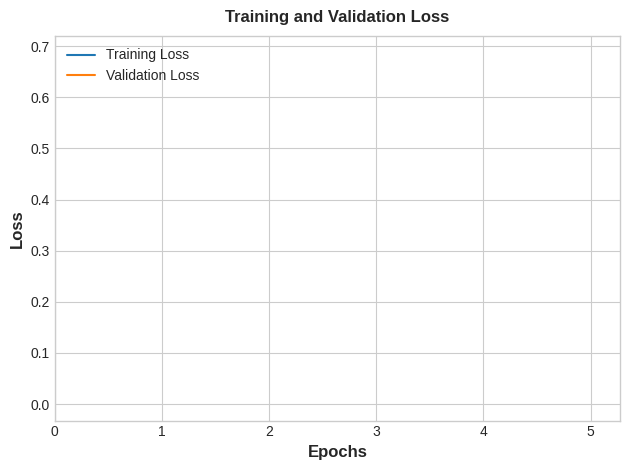

In [ ]:
from pickle import load
from matplotlib.pylab import plt
from numpy import arange


# Generate a sequence of integers to represent the epoch numbers
epochs = 5

# Plot and label the training and validation loss values
plt.plot(epochs, np.mean(train_loss), label='Training Loss')
plt.plot(epochs, np.mean(valid_loss), label='Validation Loss')

# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Set the tick locations
plt.xticks(arange(0, 6, 1))

# Display the plot
plt.legend(loc='best')
plt.show()

In [ ]:
history=model.fit(X_train,y_train,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_data=(X_test,y_test),callbacks=[EarlyStopping(patience=3,monitor='val_loss',min_delta=0.001)])

AttributeError: ignored

In [ ]:
# Loading the best model
model.load_state_dict(torch.load('./state_dict.pt'))

<All keys matched successfully>

BILSTM Testing

In [ ]:
model.eval()
y_pred_list = []
y_test_list = []
for inputs, labels in test_loader:
    inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
    print(labels)
    test_h = model.init_hidden(labels.size(0))

    output, val_h = model(inputs, test_h)
    y_pred_test = torch.argmax(output, dim=1)
    y_pred_list.extend(y_pred_test.squeeze().tolist())
    y_test_list.extend(labels.squeeze().tolist())

tensor([3, 2, 4, 3, 2, 3, 3, 0, 1, 0, 3, 0, 0, 3, 0, 4, 4, 1, 0, 2, 3, 4, 3, 0,
        3, 4, 3, 4, 4, 4, 2, 2], device='cuda:0')
tensor([0, 1, 2, 4, 0, 3, 4, 3, 1, 0, 0, 1, 4, 4, 3, 0, 1, 4, 1, 2, 1, 1, 1, 2,
        4, 2, 4, 2, 2, 3, 1, 1], device='cuda:0')
tensor([4, 2, 3, 3, 3, 1, 1, 1, 2, 1, 3, 4, 4, 0, 0, 1, 0, 4, 1, 4, 0, 4, 1, 1,
        2, 1, 0, 0, 2, 3, 4, 3], device='cuda:0')
tensor([2, 1, 3, 2, 1, 3, 1, 2, 0, 0, 3, 1, 4, 1, 3, 3, 2, 4, 4, 3, 2, 3, 3, 3,
        1, 2, 1, 3, 0, 0, 1, 0], device='cuda:0')
tensor([0, 4, 1, 3, 0, 2, 2, 3, 2, 3, 4, 0, 2, 2, 3, 3, 0, 2, 1, 2, 4, 3, 1, 2,
        2, 1, 2, 2, 0, 0, 2, 2], device='cuda:0')
tensor([1, 1, 1, 2, 3, 3, 0, 2, 2, 3, 4, 1, 2, 0, 2, 0, 0, 0, 0, 1, 3, 2, 3, 0,
        1, 4, 4, 3, 1, 4, 0, 2], device='cuda:0')
tensor([3, 1, 2, 0, 0, 2, 0, 4, 1, 4, 2, 0, 4, 3, 4, 2, 1, 3, 0, 0, 4, 4, 0, 2,
        0, 1, 2, 0, 2, 3, 0, 1], device='cuda:0')
tensor([4, 3, 1, 0, 4, 0, 4, 0, 4, 4, 3, 2, 0, 3, 2, 3, 2, 4, 3, 0, 3, 2, 1, 0,
        0,

In [ ]:
from sklearn.metrics import accuracy_score
print('Train Accuracy:', np.mean(train_acc))
print('Test Accuracy:', accuracy_score(y_test_list, y_pred_list))

print('Classification Report for Bi-LSTM :\n', classification_report(y_test_list, y_pred_list, target_names=sentiments))

Train Accuracy: 99.95067643742954
Test Accuracy: 0.9021915584415584
Classification Report for Bi-LSTM :
               precision    recall  f1-score   support

    religion       0.92      0.94      0.93      1575
         age       0.92      0.97      0.94      1559
   ethnicity       0.96      0.98      0.97      1534
      gender       0.91      0.84      0.88      1453
not bullying       0.77      0.75      0.76      1271

    accuracy                           0.90      7392
   macro avg       0.90      0.90      0.90      7392
weighted avg       0.90      0.90      0.90      7392



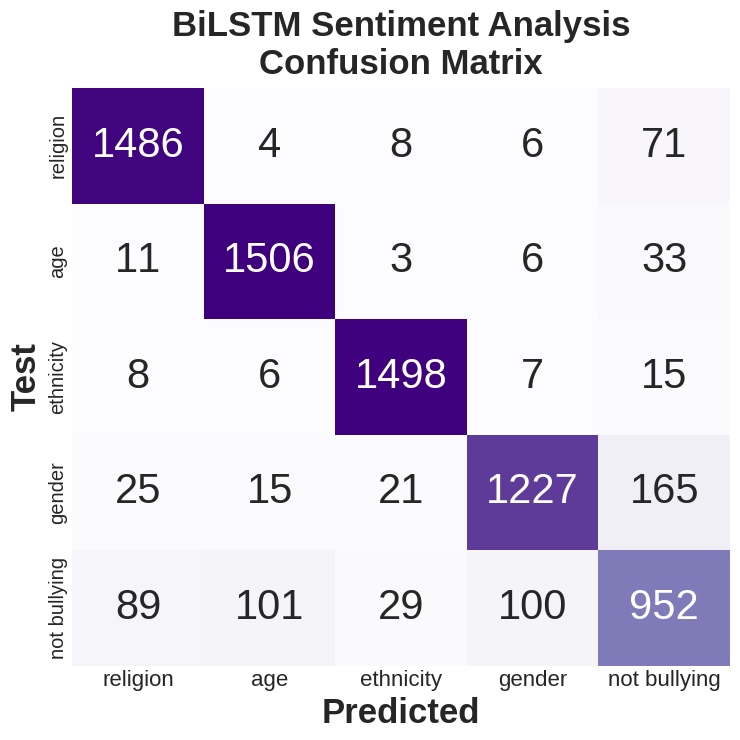

In [ ]:
conf_matrix(y_test_list,y_pred_list,'BiLSTM Sentiment Analysis\nConfusion Matrix', sentiments)

LSTM-

In [ ]:
NUM_CLASSES = 5 #We are dealing with a multiclass classification of 5 classes
HIDDEN_DIM = 100 #number of neurons of the internal state (internal neural network in the LSTM)
LSTM_LAYERS = 1 #Number of stacked LSTM layers

LR = 3e-4 #Learning rate
DROPOUT = 0.5 #LSTM Dropout
BIDIRECTIONAL = False #Boolean value to choose if to use a bidirectional LSTM or not
EPOCHS = 5 #Number of training epoch

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
class LSTM_Sentiment_Classifier(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, lstm_layers, bidirectional,batch_size, dropout):
        super(LSTM_Sentiment_Classifier,self).__init__()
        
        self.lstm_layers = lstm_layers
        self.num_directions = 2 if bidirectional else 1
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes
        self.batch_size = batch_size
        

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.lstm = nn.LSTM(embedding_dim,
                            hidden_dim,
                            num_layers=lstm_layers,
                            dropout=dropout,
                            bidirectional=bidirectional,
                            batch_first=True)

        self.fc = nn.Linear(hidden_dim*self.num_directions, num_classes)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x, hidden):
        self.batch_size = x.size(0)
        ##EMBEDDING LAYER
        embedded = self.embedding(x)
        #LSTM LAYERS
        out, hidden = self.lstm(embedded, hidden)
        #Extract only the hidden state from the last LSTM cell
        out = out[:,-1,:]
        #FULLY CONNECTED LAYERS
        out = self.fc(out)
        out = self.softmax(out)

        return out, hidden

    def init_hidden(self, batch_size):
        #Initialization of the LSTM hidden and cell states
        h0 = torch.zeros((self.lstm_layers*self.num_directions, batch_size, self.hidden_dim)).detach().to(DEVICE)
        c0 = torch.zeros((self.lstm_layers*self.num_directions, batch_size, self.hidden_dim)).detach().to(DEVICE)
        hidden = (h0, c0)
        return hidden

In [ ]:
model = LSTM_Sentiment_Classifier(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM,NUM_CLASSES, LSTM_LAYERS,BIDIRECTIONAL, BATCH_SIZE, DROPOUT)
model = model.to(DEVICE)

#Initialize embedding with the previously defined embedding matrix
model.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
#Allow the embedding matrix to be fined tuned to better adapt to out dataset and get higher accuracy
model.embedding.weight.requires_grad=True

print(model)

LSTM_Sentiment_Classifier(
  (embedding): Embedding(33009, 200)
  (lstm): LSTM(200, 100, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=100, out_features=5, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [ ]:
criterion = nn.NLLLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay = 5e-6)

In [ ]:
total_step = len(train_loader)
total_step_val = len(valid_loader)

early_stopping_patience = 4
early_stopping_counter = 0

valid_acc_max = 0 # Initialize best accuracy top 0

for e in range(EPOCHS):

    #lists to host the train and validation losses of every batch for each epoch
    train_loss, valid_loss  = [], []
    #lists to host the train and validation accuracy of every batch for each epoch
    train_acc, valid_acc  = [], []

    #lists to host the train and validation predictions of every batch for each epoch
    y_train_list, y_val_list = [], []

    #initalize number of total and correctly classified texts during training and validation
    correct, correct_val = 0, 0
    total, total_val = 0, 0
    running_loss, running_loss_val = 0, 0


    ####TRAINING LOOP####

    model.train()

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE) #load features and targets in device

        h = model.init_hidden(labels.size(0))

        model.zero_grad() #reset gradients 

        output, h = model(inputs,h) #get output and hidden states from LSTM network
        
        loss = criterion(output, labels)
        loss.backward()
        
        running_loss += loss.item()
        
        optimizer.step()

        y_pred_train = torch.argmax(output, dim=1) #get tensor of predicted values on the training set
        y_train_list.extend(y_pred_train.squeeze().tolist()) #transform tensor to list and the values to the list
        
        correct += torch.sum(y_pred_train==labels).item() #count correctly classified texts per batch
        total += labels.size(0) #count total texts per batch

    train_loss.append(running_loss / total_step)
    train_acc.append(100 * correct / total)

    ####VALIDATION LOOP####
    
    with torch.no_grad():
        
        model.eval()
        
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            val_h = model.init_hidden(labels.size(0))

            output, val_h = model(inputs, val_h)

            val_loss = criterion(output, labels)
            running_loss_val += val_loss.item()

            y_pred_val = torch.argmax(output, dim=1)
            y_val_list.extend(y_pred_val.squeeze().tolist())

            correct_val += torch.sum(y_pred_val==labels).item()
            total_val += labels.size(0)

        valid_loss.append(running_loss_val / total_step_val)
        valid_acc.append(100 * correct_val / total_val)

    #Save model if validation accuracy increases
    if np.mean(valid_acc) >= valid_acc_max:
        torch.save(model.state_dict(), './state_dict2.pt')
        print(f'Epoch {e+1}:Validation accuracy increased ({valid_acc_max:.6f} --> {np.mean(valid_acc):.6f}).  Saving model ...')
        valid_acc_max = np.mean(valid_acc)
        early_stopping_counter=0 #reset counter if validation accuracy increases
    else:
        print(f'Epoch {e+1}:Validation accuracy did not increase')
        early_stopping_counter+=1 #increase counter if validation accuracy does not increase
        
    if early_stopping_counter > early_stopping_patience:
        print('Early stopped at epoch :', e+1)
        break
    
    print(f'\tTrain_loss : {np.mean(train_loss):.4f} Val_loss : {np.mean(valid_loss):.4f}')
    print(f'\tTrain_acc : {np.mean(train_acc):.3f}% Val_acc : {np.mean(valid_acc):.3f}%')

Epoch 1:Validation accuracy increased (0.000000 --> 92.357337).  Saving model ...
	Train_loss : 0.6322 Val_loss : 0.2271
	Train_acc : 75.828% Val_acc : 92.357%
Epoch 2:Validation accuracy increased (92.357337 --> 93.274457).  Saving model ...
	Train_loss : 0.1783 Val_loss : 0.1964
	Train_acc : 94.085% Val_acc : 93.274%
Epoch 3:Validation accuracy increased (93.274457 --> 93.444293).  Saving model ...
	Train_loss : 0.1124 Val_loss : 0.2034
	Train_acc : 96.297% Val_acc : 93.444%
Epoch 4:Validation accuracy did not increase
	Train_loss : 0.0759 Val_loss : 0.2467
	Train_acc : 97.629% Val_acc : 92.459%
Epoch 5:Validation accuracy did not increase
	Train_loss : 0.0510 Val_loss : 0.2506
	Train_acc : 98.506% Val_acc : 92.289%


# LSTM Testing

In [ ]:
model.eval()
y_pred_list = []
y_test_list = []
for inputs, labels in test_loader:
    inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
    print(labels)
    test_h = model.init_hidden(labels.size(0))

    output, val_h = model(inputs, test_h)
    y_pred_test = torch.argmax(output, dim=1)
    y_pred_list.extend(y_pred_test.squeeze().tolist())
    y_test_list.extend(labels.squeeze().tolist())

tensor([1, 0, 2, 4, 4, 0, 4, 0, 2, 3, 1, 1, 0, 1, 3, 4, 3, 1, 0, 1, 3, 3, 4, 2,
        2, 0, 3, 2, 4, 1, 3, 4], device='cuda:0')
tensor([0, 2, 2, 1, 0, 2, 2, 0, 0, 0, 2, 3, 1, 0, 3, 2, 4, 1, 4, 4, 0, 4, 2, 4,
        3, 3, 3, 2, 3, 0, 2, 1], device='cuda:0')
tensor([2, 3, 2, 0, 2, 2, 4, 0, 2, 4, 4, 1, 2, 0, 4, 1, 0, 2, 4, 1, 4, 4, 4, 3,
        2, 3, 0, 1, 4, 4, 0, 0], device='cuda:0')
tensor([3, 4, 3, 3, 2, 4, 0, 3, 0, 1, 1, 4, 3, 0, 3, 2, 0, 0, 2, 3, 0, 1, 2, 3,
        4, 3, 2, 1, 2, 3, 4, 2], device='cuda:0')
tensor([3, 1, 1, 1, 4, 3, 3, 3, 0, 3, 2, 2, 4, 4, 3, 0, 0, 0, 2, 2, 2, 4, 0, 0,
        3, 1, 2, 3, 0, 3, 1, 0], device='cuda:0')
tensor([2, 4, 1, 0, 2, 4, 4, 3, 4, 1, 0, 1, 4, 3, 1, 2, 4, 4, 0, 2, 3, 2, 1, 3,
        1, 1, 1, 0, 3, 1, 3, 2], device='cuda:0')
tensor([1, 0, 3, 1, 2, 1, 0, 2, 0, 3, 4, 1, 0, 0, 1, 4, 2, 3, 0, 3, 1, 4, 1, 3,
        3, 1, 4, 0, 4, 3, 4, 4], device='cuda:0')
tensor([2, 2, 2, 3, 3, 4, 3, 4, 2, 0, 2, 3, 0, 4, 4, 0, 4, 0, 1, 4, 0, 3, 0, 1,
        4,

In [ ]:
from sklearn.metrics import accuracy_score
print(np.mean(train_acc))
print('Accuracy:',accuracy_score(y_test_list, y_pred_list))
print('Classification Report for LSTM :\n', classification_report(y_test_list, y_pred_list, target_names=sentiments))

98.50620067643743
Accuracy: 0.9243777056277056
Classification Report for LSTM :
               precision    recall  f1-score   support

    religion       0.97      0.92      0.95      1573
         age       0.98      0.96      0.97      1557
   ethnicity       0.98      0.98      0.98      1539
      gender       0.91      0.89      0.90      1454
not bullying       0.77      0.86      0.81      1269

    accuracy                           0.92      7392
   macro avg       0.92      0.92      0.92      7392
weighted avg       0.93      0.92      0.93      7392



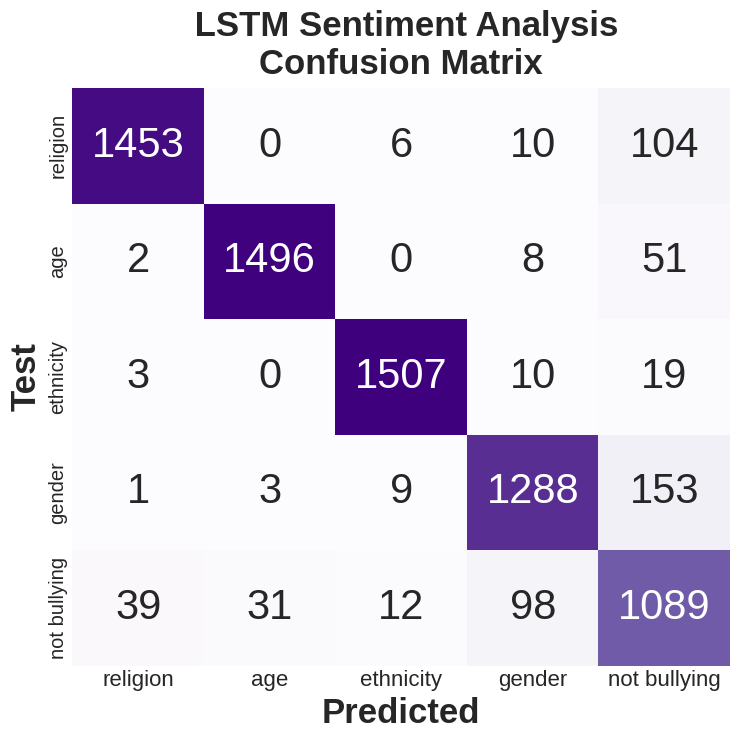

In [ ]:
conf_matrix(y_test_list,y_pred_list,' LSTM Sentiment Analysis\nConfusion Matrix', sentiments)

In [ ]:
torch.save(model, './bilstm.pt')

# **CNN**

In [ ]:
import random
import numpy as np
import math
import re
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import pickle
from sklearn.model_selection import train_test_split
from google.colab import drive
try:
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_datasets as tfds

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:

#Setting up a seed for reproducibility
seed = random.seed(42)

In [ ]:
class DCNN(tf.keras.Model):
    
    def __init__(self,
                 vocab_size,  #Size of the vocabulary used. Will be given by the tokenizer
                 emb_dim=128,  #128 is just an intuitive default value, it's used so ofter for embedding 
                 nb_filters=50,  #Number of times we want to apply each filter
                 FFN_units=512,  #Number of units of the feedforward neural network at the end
                 nb_classes=2,  #Binary classification as default
                 dropout_rate=0.5,  #To turn off certain units/parameters to avoid overfitting
                 training=False,  #True if the network is in evaluation phase. Drop out will be applied only in training
                 name="dcnn"):  #A name for the network
        super(DCNN, self).__init__(name=name)

        self.embedding = layers.Embedding(vocab_size,
                                          emb_dim)
        self.bigram = layers.Conv1D(filters=nb_filters,
                                    kernel_size=2,
                                    padding="valid",  #To add the zeros we need to performe the last convolutions
                                    activation="relu")
        self.trigram = layers.Conv1D(filters=nb_filters,
                                    kernel_size=3,
                                    padding="valid",  #To add the zeros we need to performe the last convolutions
                                    activation="relu")
        self.fourgram = layers.Conv1D(filters=nb_filters,
                                    kernel_size=4,
                                    padding="valid",  #To add the zeros we need to performe the last convolutions
                                     activation="relu")
        self.pool = layers.GlobalMaxPool1D()  #We'll be using this layer for all pooling steps
        self.dense_1 = layers.Dense(units=FFN_units, activation="relu")
        self.dropout = layers.Dropout(rate=dropout_rate)  #This is a good place to define dropout since dense_1 with create a lot of params
        if nb_classes == 2:  #Easy way to handle multiclasses
            self.last_dense = layers.Dense(units=1,
                                           activation="sigmoid")
        else:
            self.last_dense = layers.Dense(units=nb_classes,
                                           activation="softmax")
    
    def call(self, inputs, training):
        x = self.embedding(inputs)
        x_1 = self.bigram(x)
        x_1 = self.pool(x_1)
        x_2 = self.trigram(x)
        x_2 = self.pool(x_2)
        x_3 = self.fourgram(x)
        x_3 = self.pool(x_3)

        merged = tf.concat([x_1, x_2, x_3], axis=-1)  #(batch_size, 3 * nb_filters) 3 because we have 3 types of filters
        merged = self.dense_1(merged)  #Staring the feedforward process
        merged = self.dropout(merged, training)  #Applying dropout if training=True
        output = self.last_dense(merged)  
        
        return output

In [ ]:
#These are basicaly hyperparameters
EMB_DIM = 200
NB_FILTERS = 100
FFN_UNITS = 256
NB_CLASSES = 5

DROPOUT_RATE = 0.5

BATCH_SIZE = 16
NB_EPOCHS = 5

In [ ]:
dcnn = DCNN(vocab_size=VOCAB_SIZE,
            emb_dim=EMB_DIM,
            nb_filters=NB_FILTERS,
            FFN_units=FFN_UNITS,
            nb_classes=NB_CLASSES,
            dropout_rate=DROPOUT_RATE)
     


In [ ]:
if NB_CLASSES == 2:
    dcnn.compile(loss="binary_crossentropy",  #Standard loss when doing a binary classification
                 optimizer="adam",
                 metrics=["accuracy"])
else:
    dcnn.compile(loss="sparse_categorical_crossentropy",  #Standard loss when doing a multiclass classification
                 optimizer="adam",
                 metrics=["sparse_categorical_accuracy"])

In [ ]:
mod=dcnn.fit(X_train, 
         y_train,
         batch_size=BATCH_SIZE,
         epochs=NB_EPOCHS)


Epoch 1/5
1671/1671 [==============================] - 224s 133ms/step - loss: 0.2666 - sparse_categorical_accuracy: 0.9091
Epoch 2/5
1671/1671 [==============================] - 223s 134ms/step - loss: 0.1095 - sparse_categorical_accuracy: 0.9626
Epoch 3/5
1671/1671 [==============================] - 222s 133ms/step - loss: 0.0470 - sparse_categorical_accuracy: 0.9849
Epoch 4/5
1671/1671 [==============================] - 222s 133ms/step - loss: 0.0187 - sparse_categorical_accuracy: 0.9945
Epoch 5/5
1671/1671 [==============================] - 223s 133ms/step - loss: 0.0201 - sparse_categorical_accuracy: 0.9940


Text(0.5, 1.0, 'Loss vs Accuracy')

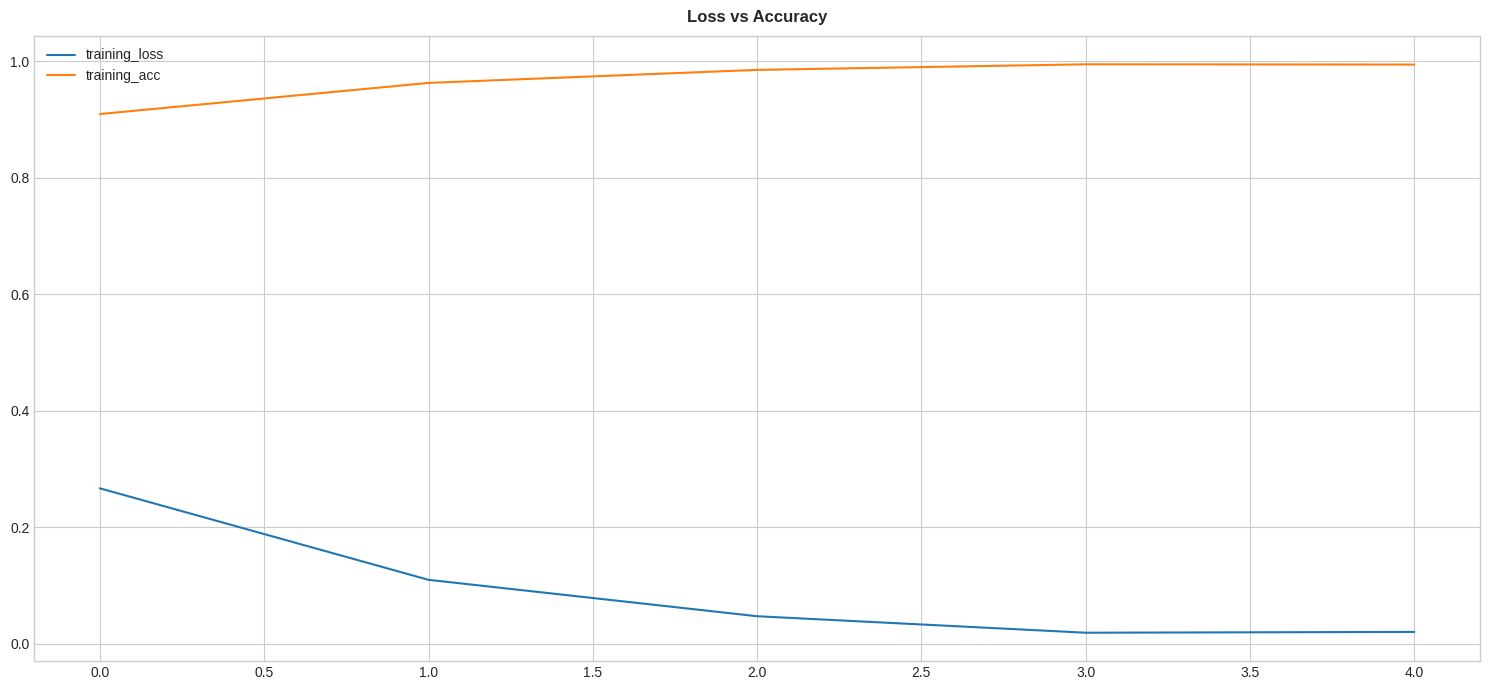

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(range(NB_EPOCHS),mod.history['loss'])
plt.plot(range(NB_EPOCHS),mod.history['sparse_categorical_accuracy'])
plt.legend(['training_loss', 'training_acc'])
plt.title('Loss vs Accuracy')

KeyError: ignored

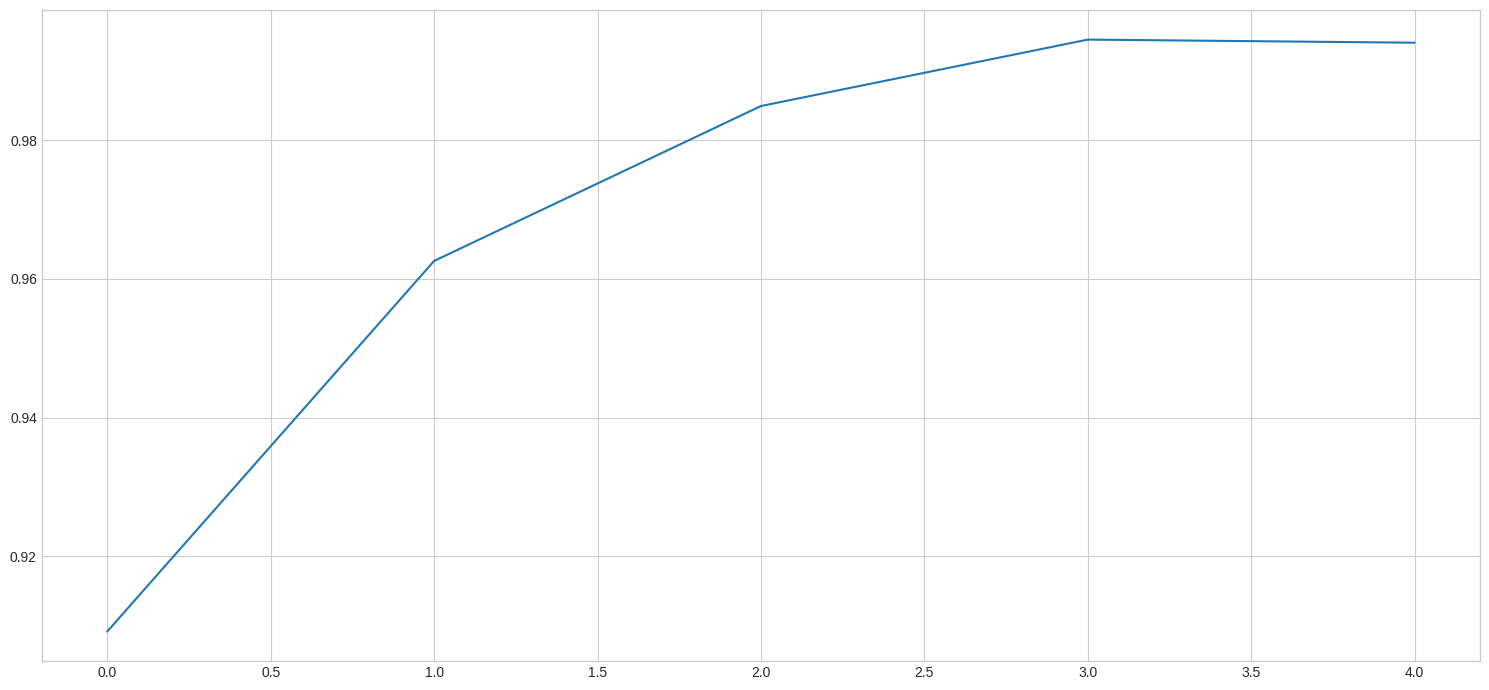

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(range(NB_EPOCHS),mod.history['sparse_categorical_accuracy'])
plt.plot(range(NB_EPOCHS),mod.history['valid_sparse_categorical_accuracy'])
plt.legend(['training_acc', 'validation_acc'])
plt.title('Accuracy')

In [ ]:
loss,results = dcnn.evaluate(X_train, y_train, batch_size=BATCH_SIZE)
print('Training acc:',results) 
loss,results = dcnn.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
print("Accuracy: ",results) 

1671/1671 [==============================] - 20s 12ms/step - loss: 0.0044 - sparse_categorical_accuracy: 0.9989
Training acc: 0.9988772869110107
464/464 [==============================] - 5s 11ms/step - loss: 0.3985 - sparse_categorical_accuracy: 0.9240
Accuracy:  0.9240199327468872


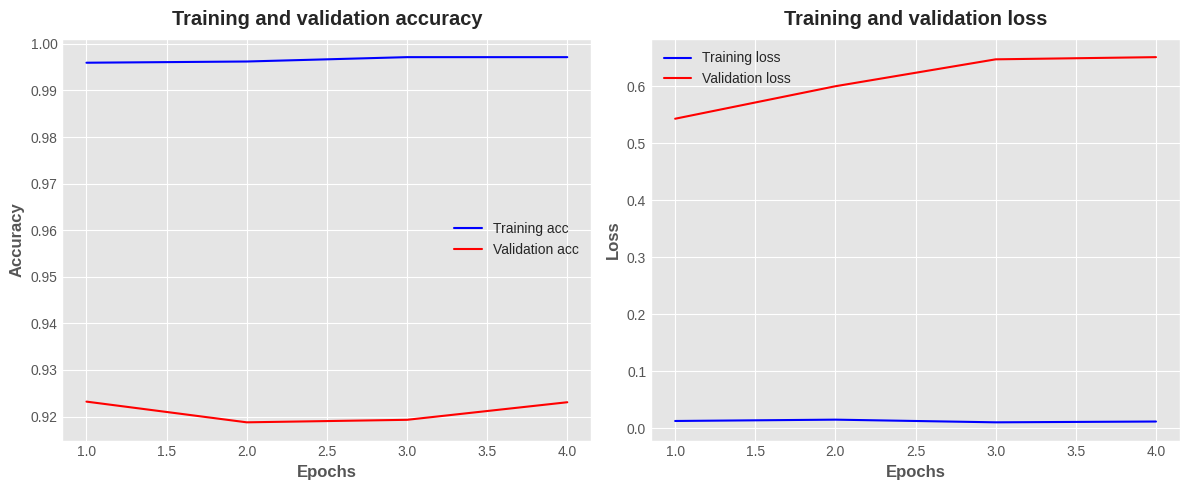

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history (history):
  acc = history.history['sparse_categorical_accuracy']
  val_acc = history.history['val_sparse_categorical_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  x = range(1, len(acc) + 1)

  plt.figure (figsize=(12, 5))

  plt.subplot (1, 2, 1)

  plt.plot (x, acc, 'b', label='Training acc')

  plt.plot (x, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.xlabel ('Epochs')

  plt.ylabel ('Accuracy')
  plt.subplot (1, 2, 2)

  plt.plot(x, loss, 'b', label='Training loss')

  plt.plot (x, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')

  plt.legend()

  plt.xlabel ('Epochs')

  plt.ylabel ('Loss')


plot_history(history)





CNN WITH DIFF OPTIMIZATION FUNCTIONS

In [ ]:
class DCNN(tf.keras.Model):
    
    def __init__(self,
                 vocab_size,  #Size of the vocabulary used. Will be given by the tokenizer
                 emb_dim=128,  #128 is just an intuitive default value, it's used so ofter for embedding 
                 nb_filters=50,  #Number of times we want to apply each filter
                 FFN_units=512,  #Number of units of the feedforward neural network at the end
                 nb_classes=2,  #Binary classification as default
                 dropout_rate=0.1,  #To turn off certain units/parameters to avoid overfitting
                 training=False,  #True if the network is in evaluation phase. Drop out will be applied only in training
                 name="dcnn"):  #A name for the network
        super(DCNN, self).__init__(name=name)

        self.embedding = layers.Embedding(vocab_size,
                                          emb_dim)
        self.bigram = layers.Conv1D(filters=nb_filters,
                                    kernel_size=2,
                                    padding="valid",  #To add the zeros we need to performe the last convolutions
                                    activation="relu")
        self.trigram = layers.Conv1D(filters=nb_filters,
                                    kernel_size=3,
                                    padding="valid",  #To add the zeros we need to performe the last convolutions
                                    activation="relu")
        self.fourgram = layers.Conv1D(filters=nb_filters,
                                    kernel_size=4,
                                    padding="valid",  #To add the zeros we need to performe the last convolutions
                                     activation="relu")
        self.pool = layers.GlobalMaxPool1D()  #We'll be using this layer for all pooling steps
        self.dense_1 = layers.Dense(units=FFN_units, activation="relu")
        self.dropout = layers.Dropout(rate=dropout_rate)  #This is a good place to define dropout since dense_1 with create a lot of params
        if nb_classes == 2:  #Easy way to handle multiclasses
            self.last_dense = layers.Dense(units=1,
                                           activation="sigmoid")
        else:
            self.last_dense = layers.Dense(units=nb_classes,
                                           activation="softmax")
    
    def call(self, inputs, training):
        x = self.embedding(inputs)
        x_1 = self.bigram(x)
        x_1 = self.pool(x_1)
        x_2 = self.trigram(x)
        x_2 = self.pool(x_2)
        x_3 = self.fourgram(x)
        x_3 = self.pool(x_3)

        merged = tf.concat([x_1, x_2, x_3], axis=-1)  #(batch_size, 3 * nb_filters) 3 because we have 3 types of filters
        merged = self.dense_1(merged)  #Staring the feedforward process
        merged = self.dropout(merged, training)  #Applying dropout if training=True
        output = self.last_dense(merged)  
        
        return output

#These are basicaly hyperparameters
EMB_DIM = 200
NB_FILTERS = 100
FFN_UNITS = 256
NB_CLASSES = 5

DROPOUT_RATE = 0.5

BATCH_SIZE = 16
NB_EPOCHS = 5
dcnn = DCNN(vocab_size=VOCAB_SIZE,
            emb_dim=EMB_DIM,
            nb_filters=NB_FILTERS,
            FFN_units=FFN_UNITS,
            nb_classes=NB_CLASSES,
            dropout_rate=DROPOUT_RATE)

if NB_CLASSES == 2:
    dcnn.compile(loss="binary_crossentropy",  #Standard loss when doing a binary classification
                 optimizer="adam",
                 metrics=["accuracy"])
else:
    dcnn.compile(loss="sparse_categorical_crossentropy",  #Standard loss when doing a multiclass classification
                 optimizer="adam",
                 metrics=["sparse_categorical_accuracy"])
     

In [ ]:
dcnn.fit(X_train, 
         y_train,
         batch_size=BATCH_SIZE,
         epochs=NB_EPOCHS)

Epoch 1/5
1671/1671 [==============================] - 39s 20ms/step - loss: 0.2697 - sparse_categorical_accuracy: 0.9070
Epoch 2/5
1671/1671 [==============================] - 14s 8ms/step - loss: 0.1123 - sparse_categorical_accuracy: 0.9622
Epoch 3/5
1671/1671 [==============================] - 14s 8ms/step - loss: 0.0470 - sparse_categorical_accuracy: 0.9855
Epoch 4/5
1671/1671 [==============================] - 13s 8ms/step - loss: 0.0217 - sparse_categorical_accuracy: 0.9928
Epoch 5/5
1671/1671 [==============================] - 12s 7ms/step - loss: 0.0155 - sparse_categorical_accuracy: 0.9952


In [ ]:
results = dcnn.evaluate(X_train, y_train, batch_size=BATCH_SIZE)
print('Training acc:',results) 

In [ ]:
results = dcnn.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
print(results) 

In [ ]:
class DCNN(tf.keras.Model):
    
    def __init__(self,
                 vocab_size,  #Size of the vocabulary used. Will be given by the tokenizer
                 emb_dim=128,  #128 is just an intuitive default value, it's used so ofter for embedding 
                 nb_filters=50,  #Number of times we want to apply each filter
                 FFN_units=512,  #Number of units of the feedforward neural network at the end
                 nb_classes=2,  #Binary classification as default
                 dropout_rate=0.1,  #To turn off certain units/parameters to avoid overfitting
                 training=False,  #True if the network is in evaluation phase. Drop out will be applied only in training
                 name="dcnn"):  #A name for the network
        super(DCNN, self).__init__(name=name)

        self.embedding = layers.Embedding(vocab_size,
                                          emb_dim)
        self.bigram = layers.Conv1D(filters=nb_filters,
                                    kernel_size=2,
                                    padding="valid",  #To add the zeros we need to performe the last convolutions
                                    activation="relu")
        self.trigram = layers.Conv1D(filters=nb_filters,
                                    kernel_size=3,
                                    padding="valid",  #To add the zeros we need to performe the last convolutions
                                    activation="relu")
        self.fourgram = layers.Conv1D(filters=nb_filters,
                                    kernel_size=4,
                                    padding="valid",  #To add the zeros we need to performe the last convolutions
                                     activation="relu")
        self.pool = layers.GlobalMaxPool1D()  #We'll be using this layer for all pooling steps
        self.dense_1 = layers.Dense(units=FFN_units, activation="relu")
        self.dropout = layers.Dropout(rate=dropout_rate)  #This is a good place to define dropout since dense_1 with create a lot of params
        if nb_classes == 2:  #Easy way to handle multiclasses
            self.last_dense = layers.Dense(units=1,
                                           activation="sigmoid")
        else:
            self.last_dense = layers.Dense(units=nb_classes,
                                           activation="softmax")
    
    def call(self, inputs, training):
        x = self.embedding(inputs)
        x_1 = self.bigram(x)
        x_1 = self.pool(x_1)
        x_2 = self.trigram(x)
        x_2 = self.pool(x_2)
        x_3 = self.fourgram(x)
        x_3 = self.pool(x_3)

        merged = tf.concat([x_1, x_2, x_3], axis=-1)  #(batch_size, 3 * nb_filters) 3 because we have 3 types of filters
        merged = self.dense_1(merged)  #Staring the feedforward process
        merged = self.dropout(merged, training)  #Applying dropout if training=True
        output = self.last_dense(merged)  
        
        return output

#These are basicaly hyperparameters
EMB_DIM = 200
NB_FILTERS = 100
FFN_UNITS = 256
NB_CLASSES = 5

DROPOUT_RATE = 0.1

BATCH_SIZE = 16
NB_EPOCHS = 2
dcnn = DCNN(vocab_size=VOCAB_SIZE,
            emb_dim=EMB_DIM,
            nb_filters=NB_FILTERS,
            FFN_units=FFN_UNITS,
            nb_classes=NB_CLASSES,
            dropout_rate=DROPOUT_RATE)

if NB_CLASSES == 2:
    dcnn.compile(loss="binary_crossentropy",  #Standard loss when doing a binary classification
                 optimizer="adam",
                 metrics=["accuracy"])
else:
    dcnn.compile(loss="sparse_categorical_crossentropy",  #Standard loss when doing a multiclass classification
                 optimizer="adam",
                 metrics=["sparse_categorical_accuracy"])

dcnn.fit(X_train, 
         y_train,
         batch_size=BATCH_SIZE,
         epochs=NB_EPOCHS)
     

Epoch 1/2
1671/1671 [==============================] - 39s 22ms/step - loss: 0.2470 - sparse_categorical_accuracy: 0.9144
Epoch 2/2
1671/1671 [==============================] - 13s 8ms/step - loss: 0.0937 - sparse_categorical_accuracy: 0.9666


In [ ]:
results = dcnn.evaluate(X_train, y_train, batch_size=BATCH_SIZE)
print(results) 

1671/1671 [==============================] - 6s 3ms/step - loss: 0.0304 - sparse_categorical_accuracy: 0.9923
[0.030401529744267464, 0.992253303527832]


In [ ]:
results = dcnn.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
print(results) 

464/464 [==============================] - 6s 12ms/step - loss: 0.2137 - sparse_categorical_accuracy: 0.9295
[0.21372291445732117, 0.9295433163642883]


dropout=0.5, batch=32, epoch=5,adam

In [ ]:
class DCNN(tf.keras.Model):
    
    def __init__(self,
                 vocab_size,  #Size of the vocabulary used. Will be given by the tokenizer
                 emb_dim=128,  #128 is just an intuitive default value, it's used so ofter for embedding 
                 nb_filters=50,  #Number of times we want to apply each filter
                 FFN_units=512,  #Number of units of the feedforward neural network at the end
                 nb_classes=2,  #Binary classification as default
                 dropout_rate=0.5,  #To turn off certain units/parameters to avoid overfitting
                 training=False,  #True if the network is in evaluation phase. Drop out will be applied only in training
                 name="dcnn"):  #A name for the network
        super(DCNN, self).__init__(name=name)

        self.embedding = layers.Embedding(vocab_size,
                                          emb_dim)
        self.bigram = layers.Conv1D(filters=nb_filters,
                                    kernel_size=2,
                                    padding="valid",  #To add the zeros we need to performe the last convolutions
                                    activation="relu")
        self.trigram = layers.Conv1D(filters=nb_filters,
                                    kernel_size=3,
                                    padding="valid",  #To add the zeros we need to performe the last convolutions
                                    activation="relu")
        self.fourgram = layers.Conv1D(filters=nb_filters,
                                    kernel_size=4,
                                    padding="valid",  #To add the zeros we need to performe the last convolutions
                                     activation="relu")
        self.pool = layers.GlobalMaxPool1D()  #We'll be using this layer for all pooling steps
        self.dense_1 = layers.Dense(units=FFN_units, activation="relu")
        self.dropout = layers.Dropout(rate=dropout_rate)  #This is a good place to define dropout since dense_1 with create a lot of params
        if nb_classes == 2:  #Easy way to handle multiclasses
            self.last_dense = layers.Dense(units=1,
                                           activation="sigmoid")
        else:
            self.last_dense = layers.Dense(units=nb_classes,
                                           activation="softmax")
    
    def call(self, inputs, training):
        x = self.embedding(inputs)
        x_1 = self.bigram(x)
        x_1 = self.pool(x_1)
        x_2 = self.trigram(x)
        x_2 = self.pool(x_2)
        x_3 = self.fourgram(x)
        x_3 = self.pool(x_3)

        merged = tf.concat([x_1, x_2, x_3], axis=-1)  #(batch_size, 3 * nb_filters) 3 because we have 3 types of filters
        merged = self.dense_1(merged)  #Staring the feedforward process
        merged = self.dropout(merged, training)  #Applying dropout if training=True
        output = self.last_dense(merged)  
        
        return output

#These are basicaly hyperparameters
EMB_DIM = 200
NB_FILTERS = 100
FFN_UNITS = 256
NB_CLASSES = 5

DROPOUT_RATE = 0.5

BATCH_SIZE = 32
NB_EPOCHS = 5
dcnn = DCNN(vocab_size=VOCAB_SIZE,
            emb_dim=EMB_DIM,
            nb_filters=NB_FILTERS,
            FFN_units=FFN_UNITS,
            nb_classes=NB_CLASSES,
            dropout_rate=DROPOUT_RATE)

if NB_CLASSES == 2:
    dcnn.compile(loss="binary_crossentropy",  #Standard loss when doing a binary classification
                 optimizer="adam",
                 metrics=["accuracy"])
else:
    dcnn.compile(loss="sparse_categorical_crossentropy",  #Standard loss when doing a multiclass classification
                 optimizer="adam",
                 metrics=["sparse_categorical_accuracy"])
     

In [ ]:
dcnn.fit(X_train, 
         y_train,
         batch_size=BATCH_SIZE,
         epochs=NB_EPOCHS)

Epoch 1/5
836/836 [==============================] - 119s 141ms/step - loss: 0.2894 - sparse_categorical_accuracy: 0.9013
Epoch 2/5
836/836 [==============================] - 119s 143ms/step - loss: 0.1024 - sparse_categorical_accuracy: 0.9659
Epoch 3/5
836/836 [==============================] - 120s 143ms/step - loss: 0.0374 - sparse_categorical_accuracy: 0.9877
Epoch 4/5
836/836 [==============================] - 118s 141ms/step - loss: 0.0145 - sparse_categorical_accuracy: 0.9953
Epoch 5/5
836/836 [==============================] - 120s 143ms/step - loss: 0.0111 - sparse_categorical_accuracy: 0.9966


In [ ]:
results = dcnn.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
print(results) 

232/232 [==============================] - 5s 22ms/step - loss: 0.3749 - sparse_categorical_accuracy: 0.9256
[0.37486255168914795, 0.9256365299224854]


rmsprop optimizer, epoch=5, batch size=32, trigram, dropout=0.3


In [ ]:
class DCNN(tf.keras.Model):
    
    def __init__(self,
                 vocab_size,  #Size of the vocabulary used. Will be given by the tokenizer
                 emb_dim=128,  #128 is just an intuitive default value, it's used so ofter for embedding 
                 nb_filters=50,  #Number of times we want to apply each filter
                 FFN_units=512,  #Number of units of the feedforward neural network at the end
                 nb_classes=2,  #Binary classification as default
                 dropout_rate=0.3,  #To turn off certain units/parameters to avoid overfitting
                 training=False,  #True if the network is in evaluation phase. Drop out will be applied only in training
                 name="dcnn"):  #A name for the network
        super(DCNN, self).__init__(name=name)

        self.embedding = layers.Embedding(vocab_size,
                                          emb_dim)
        
        self.trigram = layers.Conv1D(filters=nb_filters,
                                    kernel_size=3,
                                    padding="valid",  #To add the zeros we need to performe the last convolutions
                                    activation="relu")
        self.pool = layers.GlobalMaxPool1D()  #We'll be using this layer for all pooling steps
        self.dense_1 = layers.Dense(units=FFN_units, activation="relu")
        self.dropout = layers.Dropout(rate=dropout_rate)  #This is a good place to define dropout since dense_1 with create a lot of params
        if nb_classes == 2:  #Easy way to handle multiclasses
            self.last_dense = layers.Dense(units=1,
                                           activation="sigmoid")
        else:
            self.last_dense = layers.Dense(units=nb_classes,
                                           activation="softmax")
    
    def call(self, inputs, training):
        x = self.embedding(inputs)
        x_2 = self.trigram(x)
        x_2 = self.pool(x_2)

        merged = tf.concat([x_2], axis=-1)  #(batch_size, 3 * nb_filters) 3 because we have 3 types of filters
        merged = self.dense_1(merged)  #Staring the feedforward process
        merged = self.dropout(merged, training)  #Applying dropout if training=True
        output = self.last_dense(merged)  
        
        return output

#These are basicaly hyperparameters
EMB_DIM = 200
NB_FILTERS = 100
FFN_UNITS = 256
NB_CLASSES = 5

DROPOUT_RATE = 0.3

BATCH_SIZE = 32
NB_EPOCHS = 5
dcnn = DCNN(vocab_size=VOCAB_SIZE,
            emb_dim=EMB_DIM,
            nb_filters=NB_FILTERS,
            FFN_units=FFN_UNITS,
            nb_classes=NB_CLASSES,
            dropout_rate=DROPOUT_RATE)

if NB_CLASSES == 2:
    dcnn.compile(loss="binary_crossentropy",  #Standard loss when doing a binary classification
                 optimizer="rmsprop",
                 metrics=["accuracy"])
else:
    dcnn.compile(loss="sparse_categorical_crossentropy",  #Standard loss when doing a multiclass classification
                 optimizer="rmsprop",
                 metrics=["sparse_categorical_accuracy"])
     

In [ ]:
dcnn.fit(X_train, 
         y_train,
         batch_size=BATCH_SIZE,
         epochs=NB_EPOCHS)

Epoch 1/5
928/928 [==============================] - 35s 37ms/step - loss: 0.2730 - sparse_categorical_accuracy: 0.9077
Epoch 2/5
928/928 [==============================] - 33s 36ms/step - loss: 0.1531 - sparse_categorical_accuracy: 0.9460
Epoch 3/5
928/928 [==============================] - 31s 34ms/step - loss: 0.0968 - sparse_categorical_accuracy: 0.9678
Epoch 4/5
928/928 [==============================] - 34s 36ms/step - loss: 0.0528 - sparse_categorical_accuracy: 0.9832
Epoch 5/5
928/928 [==============================] - 31s 33ms/step - loss: 0.0217 - sparse_categorical_accuracy: 0.9938


In [ ]:
results = dcnn.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
print(results) 

232/232 [==============================] - 2s 7ms/step - loss: 0.3173 - sparse_categorical_accuracy: 0.9295
[0.31725603342056274, 0.9295433163642883]


dropout=0.1, batchsize=16, epoch=2, rmsprop, trigram

In [ ]:
class DCNN(tf.keras.Model):
    
    def __init__(self,
                 vocab_size,  #Size of the vocabulary used. Will be given by the tokenizer
                 emb_dim=128,  #128 is just an intuitive default value, it's used so ofter for embedding 
                 nb_filters=50,  #Number of times we want to apply each filter
                 FFN_units=512,  #Number of units of the feedforward neural network at the end
                 nb_classes=2,  #Binary classification as default
                 dropout_rate=0.1,  #To turn off certain units/parameters to avoid overfitting
                 training=False,  #True if the network is in evaluation phase. Drop out will be applied only in training
                 name="dcnn"):  #A name for the network
        super(DCNN, self).__init__(name=name)

        self.embedding = layers.Embedding(vocab_size,
                                          emb_dim)
        
        self.trigram = layers.Conv1D(filters=nb_filters,
                                    kernel_size=3,
                                    padding="valid",  #To add the zeros we need to performe the last convolutions
                                    activation="relu")
        self.pool = layers.GlobalMaxPool1D()  #We'll be using this layer for all pooling steps
        self.dense_1 = layers.Dense(units=FFN_units, activation="relu")
        self.dropout = layers.Dropout(rate=dropout_rate)  #This is a good place to define dropout since dense_1 with create a lot of params
        if nb_classes == 2:  #Easy way to handle multiclasses
            self.last_dense = layers.Dense(units=1,
                                           activation="sigmoid")
        else:
            self.last_dense = layers.Dense(units=nb_classes,
                                           activation="softmax")
    
    def call(self, inputs, training):
        x = self.embedding(inputs)
        x_2 = self.trigram(x)
        x_2 = self.pool(x_2)

        merged = tf.concat([x_2], axis=-1)  #(batch_size, 3 * nb_filters) 3 because we have 3 types of filters
        merged = self.dense_1(merged)  #Staring the feedforward process
        merged = self.dropout(merged, training)  #Applying dropout if training=True
        output = self.last_dense(merged)  
        
        return output

#These are basicaly hyperparameters
EMB_DIM = 200
NB_FILTERS = 100
FFN_UNITS = 256
NB_CLASSES = 5

DROPOUT_RATE = 0.1

BATCH_SIZE = 16
NB_EPOCHS = 2
dcnn = DCNN(vocab_size=VOCAB_SIZE,
            emb_dim=EMB_DIM,
            nb_filters=NB_FILTERS,
            FFN_units=FFN_UNITS,
            nb_classes=NB_CLASSES,
            dropout_rate=DROPOUT_RATE)

if NB_CLASSES == 2:
    dcnn.compile(loss="binary_crossentropy",  #Standard loss when doing a binary classification
                 optimizer="rmsprop",
                 metrics=["accuracy"])
else:
    dcnn.compile(loss="sparse_categorical_crossentropy",  #Standard loss when doing a multiclass classification
                 optimizer="rmsprop",
                 metrics=["sparse_categorical_accuracy"])
     

In [ ]:
dcnn.fit(X_train, 
         y_train,
         batch_size=BATCH_SIZE,
         epochs=NB_EPOCHS)

Epoch 1/2
1671/1671 [==============================] - 60s 36ms/step - loss: 0.2541 - sparse_categorical_accuracy: 0.9139
Epoch 2/2
1671/1671 [==============================] - 58s 35ms/step - loss: 0.1645 - sparse_categorical_accuracy: 0.9438


batchsize=32, dropout=0.1, rmsprop

In [ ]:
class DCNN(tf.keras.Model):
    
    def __init__(self,
                 vocab_size,  #Size of the vocabulary used. Will be given by the tokenizer
                 emb_dim=128,  #128 is just an intuitive default value, it's used so ofter for embedding 
                 nb_filters=50,  #Number of times we want to apply each filter
                 FFN_units=512,  #Number of units of the feedforward neural network at the end
                 nb_classes=2,  #Binary classification as default
                 dropout_rate=0.1,  #To turn off certain units/parameters to avoid overfitting
                 training=False,  #True if the network is in evaluation phase. Drop out will be applied only in training
                 name="dcnn"):  #A name for the network
        super(DCNN, self).__init__(name=name)

        self.embedding = layers.Embedding(vocab_size,
                                          emb_dim)
        
        self.trigram = layers.Conv1D(filters=nb_filters,
                                    kernel_size=3,
                                    padding="valid",  #To add the zeros we need to performe the last convolutions
                                    activation="relu")
        self.pool = layers.GlobalMaxPool1D()  #We'll be using this layer for all pooling steps
        self.dense_1 = layers.Dense(units=FFN_units, activation="relu")
        self.dropout = layers.Dropout(rate=dropout_rate)  #This is a good place to define dropout since dense_1 with create a lot of params
        if nb_classes == 2:  #Easy way to handle multiclasses
            self.last_dense = layers.Dense(units=1,
                                           activation="sigmoid")
        else:
            self.last_dense = layers.Dense(units=nb_classes,
                                           activation="softmax")
    
    def call(self, inputs, training):
        x = self.embedding(inputs)
        x_2 = self.trigram(x)
        x_2 = self.pool(x_2)

        merged = tf.concat([x_2], axis=-1)  #(batch_size, 3 * nb_filters) 3 because we have 3 types of filters
        merged = self.dense_1(merged)  #Staring the feedforward process
        merged = self.dropout(merged, training)  #Applying dropout if training=True
        output = self.last_dense(merged)  
        
        return output

#These are basicaly hyperparameters
EMB_DIM = 200
NB_FILTERS = 100
FFN_UNITS = 256
NB_CLASSES = 5

DROPOUT_RATE = 0.1

BATCH_SIZE = 32
NB_EPOCHS = 2
dcnn = DCNN(vocab_size=VOCAB_SIZE,
            emb_dim=EMB_DIM,
            nb_filters=NB_FILTERS,
            FFN_units=FFN_UNITS,
            nb_classes=NB_CLASSES,
            dropout_rate=DROPOUT_RATE)

if NB_CLASSES == 2:
    dcnn.compile(loss="binary_crossentropy",  #Standard loss when doing a binary classification
                 optimizer="rmsprop",
                 metrics=["accuracy"])
else:
    dcnn.compile(loss="sparse_categorical_crossentropy",  #Standard loss when doing a multiclass classification
                 optimizer="rmsprop",
                 metrics=["sparse_categorical_accuracy"])
     

In [ ]:
dcnn.fit(X_train, 
         y_train,
         batch_size=BATCH_SIZE,
         epochs=NB_EPOCHS)

Epoch 1/2
836/836 [==============================] - 41s 47ms/step - loss: 0.2651 - sparse_categorical_accuracy: 0.9114
Epoch 2/2
836/836 [==============================] - 41s 49ms/step - loss: 0.1532 - sparse_categorical_accuracy: 0.9459


dropout=0.1, batch=32, epoch=2, rmsprop, merged-bigram,trigram,fourgram

In [ ]:
class DCNN(tf.keras.Model):
    
    def __init__(self,
                 vocab_size,  #Size of the vocabulary used. Will be given by the tokenizer
                 emb_dim=128,  #128 is just an intuitive default value, it's used so ofter for embedding 
                 nb_filters=50,  #Number of times we want to apply each filter
                 FFN_units=512,  #Number of units of the feedforward neural network at the end
                 nb_classes=2,  #Binary classification as default
                 dropout_rate=0.1,  #To turn off certain units/parameters to avoid overfitting
                 training=False,  #True if the network is in evaluation phase. Drop out will be applied only in training
                 name="dcnn"):  #A name for the network
        super(DCNN, self).__init__(name=name)

        self.embedding = layers.Embedding(vocab_size,
                                          emb_dim)
        
        self.bigram = layers.Conv1D(filters=nb_filters,
                                    kernel_size=2,
                                    padding="valid",  #To add the zeros we need to performe the last convolutions
                                    activation="relu")
        self.trigram = layers.Conv1D(filters=nb_filters,
                                    kernel_size=3,
                                    padding="valid",  #To add the zeros we need to performe the last convolutions
                                    activation="relu")
        self.fourgram = layers.Conv1D(filters=nb_filters,
                                    kernel_size=4,
                                    padding="valid",  #To add the zeros we need to performe the last convolutions
                                     activation="relu")
        self.pool = layers.GlobalMaxPool1D()  #We'll be using this layer for all pooling steps
        self.dense_1 = layers.Dense(units=FFN_units, activation="relu")
        self.dropout = layers.Dropout(rate=dropout_rate)  #This is a good place to define dropout since dense_1 with create a lot of params
        if nb_classes == 2:  #Easy way to handle multiclasses
            self.last_dense = layers.Dense(units=1,
                                           activation="sigmoid")
        else:
            self.last_dense = layers.Dense(units=nb_classes,
                                           activation="softmax")
    
    def call(self, inputs, training):
        x = self.embedding(inputs)
        x_1 = self.bigram(x)
        x_1 = self.pool(x_1)
        x_2 = self.trigram(x)
        x_2 = self.pool(x_2)
        x_3 = self.fourgram(x)
        x_3 = self.pool(x_3)

        merged = tf.concat([x_1, x_2, x_3], axis=-1) 

        #merged = tf.concat([x_2], axis=-1)  #(batch_size, 3 * nb_filters) 3 because we have 3 types of filters
        merged = self.dense_1(merged)  #Staring the feedforward process
        merged = self.dropout(merged, training)  #Applying dropout if training=True
        output = self.last_dense(merged)  
        
        return output

#These are basicaly hyperparameters
EMB_DIM = 200
NB_FILTERS = 100
FFN_UNITS = 256
NB_CLASSES = 5

DROPOUT_RATE = 0.1

BATCH_SIZE = 32
NB_EPOCHS = 5
dcnn = DCNN(vocab_size=VOCAB_SIZE,
            emb_dim=EMB_DIM,
            nb_filters=NB_FILTERS,
            FFN_units=FFN_UNITS,
            nb_classes=NB_CLASSES,
            dropout_rate=DROPOUT_RATE)

if NB_CLASSES == 2:
    dcnn.compile(loss="binary_crossentropy",  #Standard loss when doing a binary classification
                 optimizer="rmsprop",
                 metrics=["accuracy"])
else:
    dcnn.compile(loss="sparse_categorical_crossentropy",  #Standard loss when doing a multiclass classification
                 optimizer="rmsprop",
                 metrics=["sparse_categorical_accuracy"])
     

In [ ]:
dcnn.fit(X_train, 
         y_train,
         batch_size=BATCH_SIZE,
         epochs=NB_EPOCHS)

Epoch 1/5
928/928 [==============================] - 72s 76ms/step - loss: 0.2552 - sparse_categorical_accuracy: 0.9131
Epoch 2/5
928/928 [==============================] - 70s 75ms/step - loss: 0.1424 - sparse_categorical_accuracy: 0.9507
Epoch 3/5
928/928 [==============================] - 71s 76ms/step - loss: 0.0842 - sparse_categorical_accuracy: 0.9720
Epoch 4/5
928/928 [==============================] - 69s 75ms/step - loss: 0.0366 - sparse_categorical_accuracy: 0.9886
Epoch 5/5
928/928 [==============================] - 70s 76ms/step - loss: 0.0144 - sparse_categorical_accuracy: 0.9956


In [ ]:
results = dcnn.evaluate(X_test, y_test, batch_size=32)
print(results) 

232/232 [==============================] - 5s 21ms/step - loss: 0.3601 - sparse_categorical_accuracy: 0.9330
[0.36011409759521484, 0.9330459237098694]


ADAMAX OPTIMIZER

In [ ]:
class DCNN(tf.keras.Model):
    
    def __init__(self,
                 vocab_size,  #Size of the vocabulary used. Will be given by the tokenizer
                 emb_dim=128,  #128 is just an intuitive default value, it's used so ofter for embedding 
                 nb_filters=50,  #Number of times we want to apply each filter
                 FFN_units=512,  #Number of units of the feedforward neural network at the end
                 nb_classes=2,  #Binary classification as default
                 dropout_rate=0.1,  #To turn off certain units/parameters to avoid overfitting
                 training=False,  #True if the network is in evaluation phase. Drop out will be applied only in training
                 name="dcnn"):  #A name for the network
        super(DCNN, self).__init__(name=name)

        self.embedding = layers.Embedding(vocab_size,
                                          emb_dim)
        
        self.bigram = layers.Conv1D(filters=nb_filters,
                                    kernel_size=2,
                                    padding="valid",  #To add the zeros we need to performe the last convolutions
                                    activation="relu")
        self.trigram = layers.Conv1D(filters=nb_filters,
                                    kernel_size=3,
                                    padding="valid",  #To add the zeros we need to performe the last convolutions
                                    activation="relu")
        self.fourgram = layers.Conv1D(filters=nb_filters,
                                    kernel_size=4,
                                    padding="valid",  #To add the zeros we need to performe the last convolutions
                                     activation="relu")
        self.pool = layers.GlobalMaxPool1D()  #We'll be using this layer for all pooling steps
        self.dense_1 = layers.Dense(units=FFN_units, activation="relu")
        self.dropout = layers.Dropout(rate=dropout_rate)  #This is a good place to define dropout since dense_1 with create a lot of params
        if nb_classes == 2:  #Easy way to handle multiclasses
            self.last_dense = layers.Dense(units=1,
                                           activation="sigmoid")
        else:
            self.last_dense = layers.Dense(units=nb_classes,
                                           activation="softmax")
    
    def call(self, inputs, training):
        x = self.embedding(inputs)
        x_1 = self.bigram(x)
        x_1 = self.pool(x_1)
        x_2 = self.trigram(x)
        x_2 = self.pool(x_2)
        x_3 = self.fourgram(x)
        x_3 = self.pool(x_3)

        merged = tf.concat([x_1, x_2, x_3], axis=-1) 

        #merged = tf.concat([x_2], axis=-1)  #(batch_size, 3 * nb_filters) 3 because we have 3 types of filters
        merged = self.dense_1(merged)  #Staring the feedforward process
        merged = self.dropout(merged, training)  #Applying dropout if training=True
        output = self.last_dense(merged)  
        
        return output

#These are basicaly hyperparameters
EMB_DIM = 200
NB_FILTERS = 100
FFN_UNITS = 256
NB_CLASSES = 5

DROPOUT_RATE = 0.1

BATCH_SIZE = 16
NB_EPOCHS = 2
dcnn = DCNN(vocab_size=VOCAB_SIZE,
            emb_dim=EMB_DIM,
            nb_filters=NB_FILTERS,
            FFN_units=FFN_UNITS,
            nb_classes=NB_CLASSES,
            dropout_rate=DROPOUT_RATE)

if NB_CLASSES == 2:
    dcnn.compile(loss="binary_crossentropy",  #Standard loss when doing a binary classification
                 optimizer="adamax",
                 metrics=["accuracy"])
else:
    dcnn.compile(loss="sparse_categorical_crossentropy",  #Standard loss when doing a multiclass classification
                 optimizer="adamax",
                 metrics=["sparse_categorical_accuracy"])
     

In [ ]:
dcnn.fit(X_train, 
         y_train,
         batch_size=BATCH_SIZE,
         epochs=NB_EPOCHS)

Epoch 1/2
1671/1671 [==============================] - 76s 45ms/step - loss: 0.3150 - sparse_categorical_accuracy: 0.8954
Epoch 2/2
1671/1671 [==============================] - 73s 44ms/step - loss: 0.1671 - sparse_categorical_accuracy: 0.9408


In [ ]:
results = dcnn.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
print(results) 

464/464 [==============================] - 6s 12ms/step - loss: 0.1969 - sparse_categorical_accuracy: 0.9281
[0.1968829482793808, 0.9280614256858826]


NADAM OPTIMIZER

In [ ]:
class DCNN(tf.keras.Model):
    
    def __init__(self,
                 vocab_size,  #Size of the vocabulary used. Will be given by the tokenizer
                 emb_dim=128,  #128 is just an intuitive default value, it's used so ofter for embedding 
                 nb_filters=50,  #Number of times we want to apply each filter
                 FFN_units=512,  #Number of units of the feedforward neural network at the end
                 nb_classes=2,  #Binary classification as default
                 dropout_rate=0.1,  #To turn off certain units/parameters to avoid overfitting
                 training=False,  #True if the network is in evaluation phase. Drop out will be applied only in training
                 name="dcnn"):  #A name for the network
        super(DCNN, self).__init__(name=name)

        self.embedding = layers.Embedding(vocab_size,
                                          emb_dim)
        
        self.bigram = layers.Conv1D(filters=nb_filters,
                                    kernel_size=2,
                                    padding="valid",  #To add the zeros we need to performe the last convolutions
                                    activation="relu")
        self.trigram = layers.Conv1D(filters=nb_filters,
                                    kernel_size=3,
                                    padding="valid",  #To add the zeros we need to performe the last convolutions
                                    activation="relu")
        self.fourgram = layers.Conv1D(filters=nb_filters,
                                    kernel_size=4,
                                    padding="valid",  #To add the zeros we need to performe the last convolutions
                                     activation="relu")
        self.pool = layers.GlobalMaxPool1D()  #We'll be using this layer for all pooling steps
        self.dense_1 = layers.Dense(units=FFN_units, activation="relu")
        self.dropout = layers.Dropout(rate=dropout_rate)  #This is a good place to define dropout since dense_1 with create a lot of params
        if nb_classes == 2:  #Easy way to handle multiclasses
            self.last_dense = layers.Dense(units=1,
                                           activation="sigmoid")
        else:
            self.last_dense = layers.Dense(units=nb_classes,
                                           activation="softmax")
    
    def call(self, inputs, training):
        x = self.embedding(inputs)
        x_1 = self.bigram(x)
        x_1 = self.pool(x_1)
        x_2 = self.trigram(x)
        x_2 = self.pool(x_2)
        x_3 = self.fourgram(x)
        x_3 = self.pool(x_3)

        merged = tf.concat([x_1, x_2, x_3], axis=-1) 

        #merged = tf.concat([x_2], axis=-1)  #(batch_size, 3 * nb_filters) 3 because we have 3 types of filters
        merged = self.dense_1(merged)  #Staring the feedforward process
        merged = self.dropout(merged, training)  #Applying dropout if training=True
        output = self.last_dense(merged)  
        
        return output

#These are basicaly hyperparameters
EMB_DIM = 200
NB_FILTERS = 100
FFN_UNITS = 256
NB_CLASSES = 5

DROPOUT_RATE = 0.1

BATCH_SIZE = 16
NB_EPOCHS = 2
dcnn = DCNN(vocab_size=VOCAB_SIZE,
            emb_dim=EMB_DIM,
            nb_filters=NB_FILTERS,
            FFN_units=FFN_UNITS,
            nb_classes=NB_CLASSES,
            dropout_rate=DROPOUT_RATE)

if NB_CLASSES == 2:
    dcnn.compile(loss="binary_crossentropy",  #Standard loss when doing a binary classification
                 optimizer="nadam",
                 metrics=["accuracy"])
else:
    dcnn.compile(loss="sparse_categorical_crossentropy",  #Standard loss when doing a multiclass classification
                 optimizer="nadam",
                 metrics=["sparse_categorical_accuracy"])
     

In [ ]:
dcnn.fit(X_train, 
         y_train,
         batch_size=BATCH_SIZE,
         epochs=NB_EPOCHS)

Epoch 1/2
1671/1671 [==============================] - 144s 85ms/step - loss: 0.2436 - sparse_categorical_accuracy: 0.9160
Epoch 2/2
1671/1671 [==============================] - 143s 85ms/step - loss: 0.0966 - sparse_categorical_accuracy: 0.9661


In [ ]:
results = dcnn.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
print(results) 

464/464 [==============================] - 6s 13ms/step - loss: 0.2197 - sparse_categorical_accuracy: 0.9286
[0.21965962648391724, 0.9286003112792969]


AMSGRAD

In [ ]:
class DCNN(tf.keras.Model):
    
    def __init__(self,
                 vocab_size,  #Size of the vocabulary used. Will be given by the tokenizer
                 emb_dim=128,  #128 is just an intuitive default value, it's used so ofter for embedding 
                 nb_filters=50,  #Number of times we want to apply each filter
                 FFN_units=512,  #Number of units of the feedforward neural network at the end
                 nb_classes=2,  #Binary classification as default
                 dropout_rate=0.5,  #To turn off certain units/parameters to avoid overfitting
                 training=False,  #True if the network is in evaluation phase. Drop out will be applied only in training
                 name="dcnn"):  #A name for the network
        super(DCNN, self).__init__(name=name)

        self.embedding = layers.Embedding(vocab_size,
                                          emb_dim)
        
        self.trigram = layers.Conv1D(filters=nb_filters,
                                    kernel_size=3,
                                    padding="valid",  #To add the zeros we need to performe the last convolutions
                                    activation="relu")
        self.pool = layers.GlobalMaxPool1D()  #We'll be using this layer for all pooling steps
        self.dense_1 = layers.Dense(units=FFN_units, activation="relu")
        self.dropout = layers.Dropout(rate=dropout_rate)  #This is a good place to define dropout since dense_1 with create a lot of params
        if nb_classes == 2:  #Easy way to handle multiclasses
            self.last_dense = layers.Dense(units=1,
                                           activation="sigmoid")
        else:
            self.last_dense = layers.Dense(units=nb_classes,
                                           activation="softmax")
    
    def call(self, inputs, training):
        x = self.embedding(inputs)
        
        x_2 = self.trigram(x)
        x_2 = self.pool(x_2)
        

        merged = tf.concat([ x_2], axis=-1) 

        #merged = tf.concat([x_2], axis=-1)  #(batch_size, 3 * nb_filters) 3 because we have 3 types of filters
        merged = self.dense_1(merged)  #Staring the feedforward process
        merged = self.dropout(merged, training)  #Applying dropout if training=True
        output = self.last_dense(merged)  
        
        return output

#These are basicaly hyperparameters
EMB_DIM = 200
NB_FILTERS = 100
FFN_UNITS = 256
NB_CLASSES = 5

DROPOUT_RATE = 0.5

BATCH_SIZE = 16
NB_EPOCHS = 2
dcnn = DCNN(vocab_size=VOCAB_SIZE,
            emb_dim=EMB_DIM,
            nb_filters=NB_FILTERS,
            FFN_units=FFN_UNITS,
            nb_classes=NB_CLASSES,
            dropout_rate=DROPOUT_RATE)

if NB_CLASSES == 2:
    dcnn.compile(loss="binary_crossentropy",  #Standard loss when doing a binary classification
                 optimizer="adam",
                 metrics=["accuracy"])
else:
    dcnn.compile(loss="sparse_categorical_crossentropy",  #Standard loss when doing a multiclass classification
                 optimizer="adam",
                 metrics=["sparse_categorical_accuracy"])
    
dcnn.fit(X_train, 
         y_train,
         batch_size=BATCH_SIZE,
         epochs=NB_EPOCHS)

Epoch 1/2
1671/1671 [==============================] - 131s 78ms/step - loss: 0.2724 - sparse_categorical_accuracy: 0.9051
Epoch 2/2
1671/1671 [==============================] - 130s 78ms/step - loss: 0.1109 - sparse_categorical_accuracy: 0.9632


In [ ]:
results = dcnn.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
print(results) 

464/464 [==============================] - 3s 6ms/step - loss: 0.2063 - sparse_categorical_accuracy: 0.9273
[0.20634682476520538, 0.9272531270980835]
